In [57]:
import numpy as np
import scipy
import sklearn.manifold
import seaborn as sns
import matplotlib.pyplot as plt
import pandas
import pickle
import os

In [58]:
INPUT = '../../histnorm/datasets/historical/german/german-anselm.test.txt'
ENCODING = 'utf-8'

# Loading input file, which has the original and modernised token in each line separated by a \t
with open(INPUT, 'r', encoding=ENCODING) as infile:
    tokens = [line.strip().split('\t') for line in infile]

In [59]:
# Getting the original and modernised tokens and types
tokens_original = [token[0] for token in tokens]
tokens_modernised = [token[1] for token in tokens]

types_original = list(set(tokens_original))
types_modernised = list(set(tokens_modernised))

In [60]:
def ttr(types, tokens):
    """
    Calculating Type-Token Ration
    """
    return len(types)/len(tokens)

assert ttr([0]*5, [0]*10)  == 0.5
assert ttr([0]*10, [0]*10) == 1

In [61]:
print('Tokens Original Example: {}'.format(tokens_original[:10]))
print('Tokens Original Count: {}'.format(len(tokens_original)))
print('Types Original Example: {}'.format(types_original[:10]))
print('Types Original Count: {}'.format(len(types_original)))
print('Type/Token Ratio Original: {:2.2%}'.format(ttr(types_original, tokens_original)))

Tokens Original Example: ['ſprach', 'myn', 'libes', 'kint', 'ich', 'habe', 'vffenbarlich', 'gelart', 'vnd', 'nicht']
Tokens Original Count: 45999
Types Original Example: ['ſenfftiglichen', 'mo͗cht', 'daz', 'sprechent', 'iūg͛', 'ſuezer', 'ſleheſt', 'czartē', 'gefangin', 'fruͤ']
Types Original Count: 7647
Type/Token Ratio Original: 16.62%


In [62]:
print('Tokens Modernised Example: {}'.format(tokens_modernised[:10]))
print('Tokens Modernised Count: {}'.format(len(tokens_modernised)))
print('Types Modernised Example: {}'.format(types_modernised[:10]))
print('Types Modernised Count: {}'.format(len(types_modernised)))
print('Type/Token Modernised Original: {:2.2%}'.format(ttr(types_modernised, tokens_modernised)))

Tokens Modernised Example: ['sprach', 'mein', 'liebes', 'kind', 'ich', 'habe', 'offenbarlich', 'gelehrt', 'und', 'nicht']
Tokens Modernised Count: 45999
Types Modernised Example: ['fackeln', 'guotlich', 'martha', 'brot', 'berichte', 'eingegangen', 'wem', 'hebt', 'konnten', 'verliest']
Types Modernised Count: 2488
Type/Token Modernised Original: 5.41%


In [63]:
def levenshtein(string1, string2):
    """
    Levenshtein Distance between two strings
    """
    if string1 == string2:
        return 0

    rows = len(string1) + 1
    cols = len(string2) + 1
    dist = [[0 for c in range(cols)] for r in range(rows)]

    for j in range(1, rows):
        dist[j][0] = j
    for i in range(1, cols):
        dist[0][i] = i

    for col in range(1, cols):
        for row in range(1, rows):
            cost = 1
            if string1[row - 1] == string2[col - 1]:
                cost = 0
            dist[row][col] = min(dist[row - 1][col] + 1, dist[row][col - 1] + 1, dist[row - 1][col - 1] + cost)

    return dist[row][col]

assert levenshtein('foobar', 'foobar') == 0
assert levenshtein('foobar', 'foubar') == 1
assert levenshtein('foobar', 'fuubar') == 2

In [65]:
%%time

similarity = levenshtein
cache_name = 'german-anselm-pairwise-distance.pickle'

if os.path.exists(cache_name):
    print('> Using Cache')
    # Unpacking pickled Pairwise Distances
    with open(cache_name, 'rb' ) as pickler:    
        cache = pickle.load(pickler)
        types_original_pairwise_distance = cache['types_original_pairwise_distance']
        types_modernised_pairwise_distance = cache['types_modernised_pairwise_distance']

else:
    # Calculating string distances for each type
    types_original_reshaped = np.array(types_original).reshape(-1,1)
    types_original_pairwise_distance = scipy.spatial.distance.pdist(types_original_reshaped, lambda x,y: similarity(str(x[0]),str(y[0])))   

    types_modernised_reshaped = np.array(types_modernised).reshape(-1,1)
    types_modernised_pairwise_distance = scipy.spatial.distance.pdist(types_modernised_reshaped, lambda x,y: similarity(str(x[0]),str(y[0])))   

    print('> Writing Cache')
    with open(cache_name, 'wb' ) as pickler:
        data = {
            'types_original_pairwise_distance': types_original_pairwise_distance,
            'types_modernised_pairwise_distance': types_modernised_pairwise_distance
        }
        pickle.dump(types_modernised_pairwise_distance, pickler) 

> Writing Cache
CPU times: user 11min 57s, sys: 177 ms, total: 11min 57s
Wall time: 11min 57s


In [66]:
%%time
# Transforming pairwise distances into a full similarity matrix
original_distance_matrix = pandas.DataFrame(scipy.spatial.distance.squareform(types_original_pairwise_distance), index=types_original, columns=types_original)
modernised_distance_matrix = pandas.DataFrame(scipy.spatial.distance.squareform(types_modernised_pairwise_distance), index=types_modernised, columns=types_modernised)

CPU times: user 298 ms, sys: 160 ms, total: 458 ms
Wall time: 457 ms


In [67]:
%%time
# Running t-SNE on similarity matrix

cache_name = 'german-anselm-tsne.pickle'

if os.path.exists(cache_name):
    print('> Using Cache')
    # Unpacking pickled Pairwise Distances
    with open(cache_name, 'rb' ) as pickler:    
        cache = pickle.load(pickler)
        original_similarity_embedded = cache['original_similarity_embedded']
        modernised_similarity_embedded = cache['modernised_similarity_embedded']

else:
    original_similarity_embedded = sklearn.manifold.TSNE(n_components=2).fit_transform(original_distance_matrix)
    modernised_similarity_embedded = sklearn.manifold.TSNE(n_components=2).fit_transform(modernised_distance_matrix)
    
    print('> Writing Cache')
    with open(cache_name, 'wb' ) as pickler:
        data = {
            'original_similarity_embedded': original_similarity_embedded,
            'modernised_similarity_embedded': modernised_similarity_embedded
        }
        pickle.dump(types_modernised_pairwise_distance, pickler) 


CPU times: user 12min 57s, sys: 70.8 ms, total: 12min 57s
Wall time: 9min 21s


In [69]:
original_tsne = pandas.DataFrame()
original_tsne['tsne-x-original'] = original_similarity_embedded[:,0]
original_tsne['tsne-y-original'] = original_similarity_embedded[:,1]

modernised_tsne = pandas.DataFrame()
modernised_tsne['tsne-x-modernised'] = modernised_similarity_embedded[:,0]
modernised_tsne['tsne-y-modernised'] = modernised_similarity_embedded[:,1]

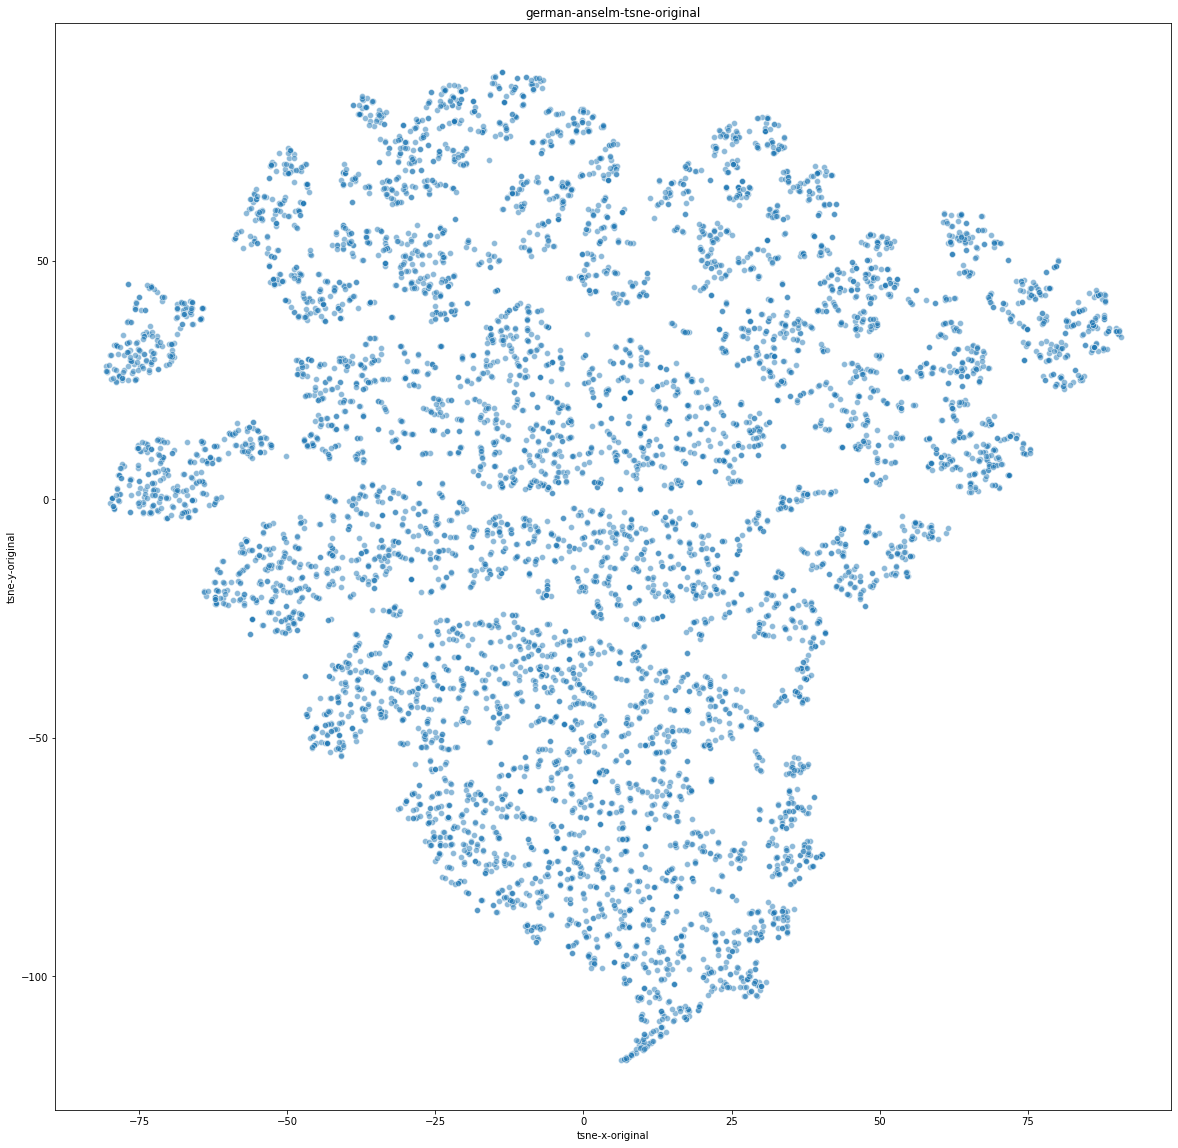

In [87]:
plt.figure(figsize=(20,20))
sns.scatterplot(
    x="tsne-x-original", y="tsne-y-original",
    data=original_tsne,
    alpha=0.5
).set_title("german-anselm-tsne-original")

plt.savefig('german-anselm-tsne-original.png', 
            facecolor='white',
            bbox_inches='tight', 
            dpi=300,
            pad_inches=0.1)

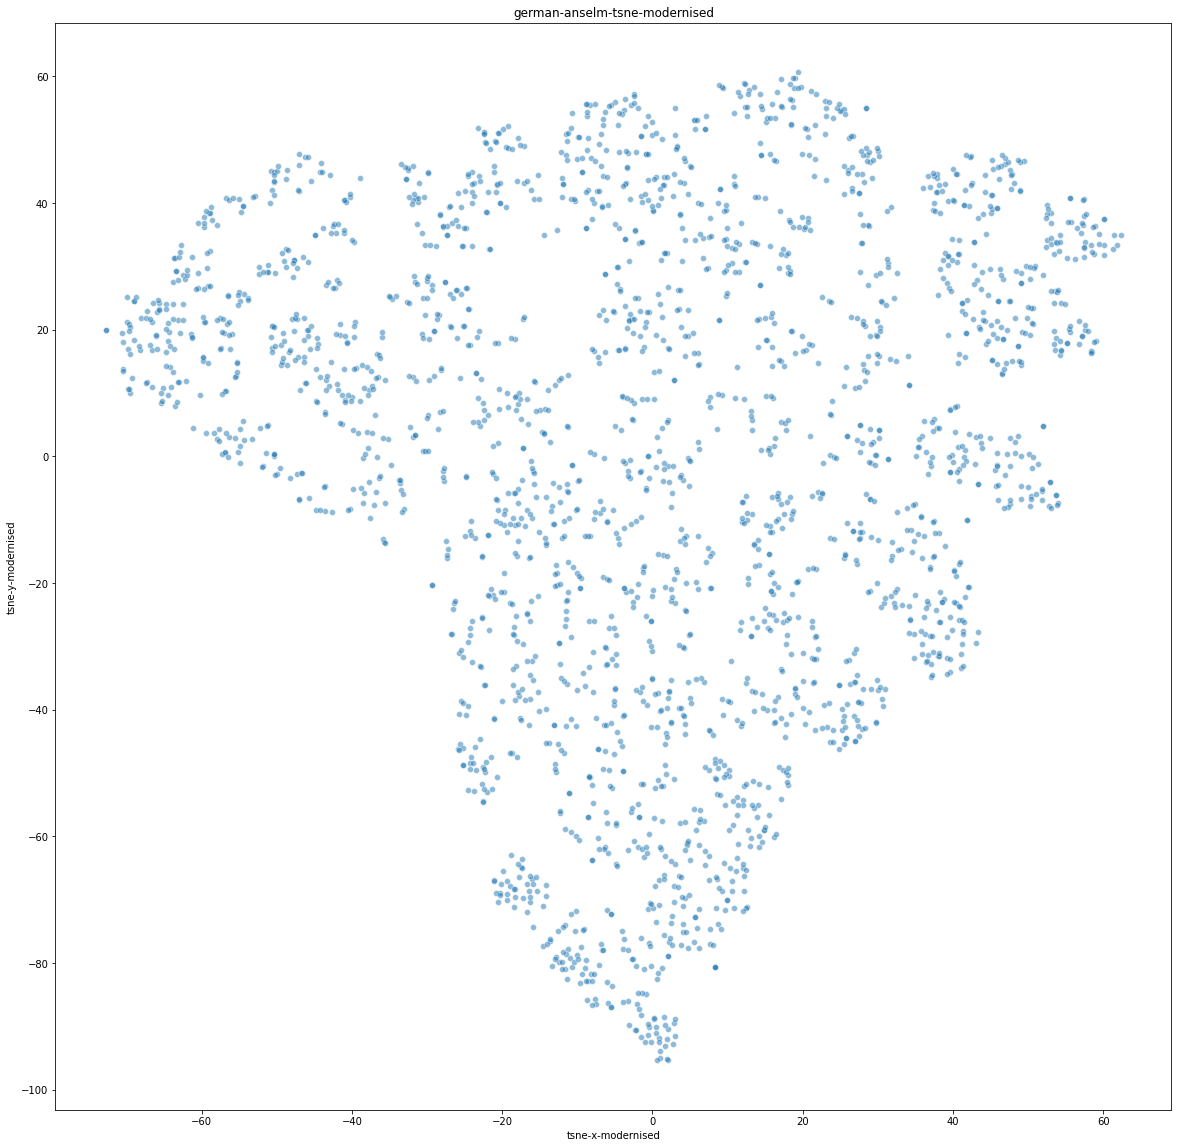

In [88]:
plt.figure(figsize=(20,20))
sns.scatterplot(
    x="tsne-x-modernised", y="tsne-y-modernised",
    data=modernised_tsne,
    alpha=0.5
).set_title("german-anselm-tsne-modernised")

plt.savefig('german-anselm-tsne-modernised.png', 
            facecolor='white',
            bbox_inches='tight', 
            dpi=300,
            pad_inches=0.1)

In [ ]:
# TODO: Test UMAP Results

In [72]:
%%time

# Clustering the pairwise distances
linkage_method = 'ward'
original_clustering = scipy.cluster.hierarchy.linkage(types_original_pairwise_distance, linkage_method)

In [74]:
from functools import reduce
from json import dump

labels = dict(enumerate(types_original))

def add_nodes(node, parent):
    """
    Recursively build tree as dict
    """
    new_node = dict(node_id=node.id, children=[], distance=node.dist)
    parent['children'].append(new_node)
    if node.left: add_nodes(node.left, new_node)
    if node.right: add_nodes(node.right, new_node)

def add_labels(node):
    """
    Recursively add labels to the tree
    """
    is_leaf = len(node['children']) == 0

    if is_leaf: 
        node['name'] = labels[node['node_id']]
    else:
        list(map(add_labels, node['children']))  
    del node['node_id']

if not os.path.exists('german-anselm-cluster-original.json'):
    # Transforming Cluster into JSON Tree
    scipy_tree = scipy.cluster.hierarchy.to_tree(original_clustering, rd=False)
    tree = dict(name='root', children=[], distance=scipy_tree.dist)
    
    add_nodes(scipy_tree, tree)
    add_labels(tree['children'][0])
    
    with open('german-anselm-cluster-original.json', 'w') as clustering:
        dump(tree, clustering, indent=1)